In [9]:
import scipy.io
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

In [10]:

class BData():
    def __init__(self, skeleton_location, VGG_location):
        print("Loading data")
        self.skelly = []
        self.skeleton = np.array(
            scipy.io.loadmat(skeleton_location)["skeldata"])[:, 1:].transpose()
        self.VGG = np.array(scipy.io.loadmat(
            VGG_location)["features"]).transpose()

    def center_data(self, df):
        print()
        print("Centering data")
        # center the data
        df = df - df.mean()
        return df

    def EDA_VGG(self):
        print()
        print("VGG EDA")
        self.VGG_df = pd.DataFrame(self.VGG)
        print(self.VGG_df.describe())

    def EDA_skelly(self):
        print()
        print("Skelly EDA")
        # index obtains the indexes of the columns by concatenating the strings "x", "y" and "p" with the numbers 1 to 18
        # and then concatenating the strings with the numbers 1 to 6 and putting them in a list
        index = [j+str(i+1) for j in ["x", "y", "p"]
                 for i in range(int((self.skeleton[0, :].shape[0]-1)/3))]
        # skeleton_df is a dataframe with the skeleton data and the indexes are the columns
        self.skeleton_df = pd.DataFrame(
            self.skeleton, columns=["f", *index])
        # describe the data
        # plot the data
        max_frame = max([
            self.skeleton_df[self.skeleton_df.f == i].shape[0] for i in range(int(self.skeleton_df["f"].max()))])
        # ts = self.skeleton_df.plot.scatter(x='x1', y='y1')
        # ts.plot()
        # plt.show()
        skelly_aux = []
        for i in range(18):
            # drop the p of the joints
            self.skeleton_df = self.skeleton_df.drop(
                columns=["p"+str(i+1)])
        skelly_aux = []
        for i in range(int(self.skeleton_df["f"].max())):
            # skelly is a dataframe with the skeleton data of the frame i
            skelly = self.skeleton_df[self.skeleton_df.f == i].drop(
                columns="f")
            middle_point = np.array([skelly["x1"],
                                     skelly["y1"]])
            if middle_point.shape[1] == 0:
                n = 0
                mean = [0]*34
                autocorrolation = [0]*34

            else:
                n = len(middle_point)
                skelly = skelly.drop(
                    columns=["x1", "y1"]).transpose().values.reshape(
                    -1, middle_point.shape[1]*2)
                skelly = ((skelly-middle_point.reshape(1, -1))
                          ).transpose().reshape(-1, 34)
                mean = skelly.mean(axis=0)
                # autocorrolation = skelly.apply(
                #    lambda col: col.autocorr(1), axis=0){i}")
            #     mean_string.append(f"mean_Y{i}")
            #     autocorrolation_string.append(f"autocorr_X{i}")
            #     autocorrolation_string.append(f"autocorr_Y{i}")

            # # pad the data with 0s to have the same number of frames
            # if skelly.shape[0] < max_frame:
            #     skelly = np.pad(
            #         skelly, ((0, max_frame - skelly.shape[0]), (0, 0)), mode='constant')

                # mean_string = []
            autocorrolation_string = []

            # for i in range(1, 19):
            #     mean.append(skelly[f"x{i}"].mean())
            #     mean.append(skelly[f"y{i}"].mean())
            #     autocorrolation.append(skelly[f"x{i}"].autocorr())
            #     autocorrolation.append(skelly[f"y{i}"].autocorr())
            #     mean_string.append(f"mean_X{i}")
            #     mean_string.append(f"mean_Y{i}")
            #     autocorrolation_string.append(f"autocorr_X{i}")
            #     autocorrolation_string.append(f"autocorr_Y{i}")

            # # pad the data with 0s to have the same number of frames
            # if skelly.shape[0] < max_frame:
            #     skelly = np.pad(
            #         skelly, ((0, max_frame - skelly.shape[0]), (0, 0)), mode='constant')

            # Flatten the matrices into vectors
            # vector = np.reshape(skelly, -1)
            skelly_aux.append([n, *mean])

        print(self.skeleton_df.describe())

        # skeleton_df is a dataframe with the skeleton data of all frames
        self.skeleton_df = pd.DataFrame(
            skelly_aux)

        # correlation = self.skeleton_df.corr()
        # sns.heatmap(correlation, xticklabels=correlation.columns,
        # yticklabels=correlation.index, annot=True)
        # plt.show()

    def PCA_VGG(self):
        print()
        print("PCA VGG")
        print(np.linalg.matrix_rank(self.VGG_df))

        steps = [('scaling', StandardScaler()),
                 ('pca', PCA(n_components=0.9))]
        # create the pipeline
        pipeline = Pipeline(steps)
        # fit the pipeline
        pipeline.fit(self.VGG_df)
        # transform the data
        reduced = pipeline.inverse_transform(
            pipeline.transform(self.VGG_df))
        # create a dataframe with the reduced data
        self.VGG_df = pd.DataFrame(reduced)
        # rank of vgg_df
        print(np.linalg.matrix_rank(self.VGG_df))

    def PCA_skelly(self):
        print()
        print("PCA Skelly")
        print(np.linalg.matrix_rank(self.skeleton_df))
        steps = [('scaling', StandardScaler()),
                 ('pca', PCA(n_components=0.90))]
        pipeline = Pipeline(steps)
        pipeline.fit(self.skeleton_df)
        reduced = pipeline.inverse_transform(
            pipeline.transform(self.skeleton_df))
        self.skeleton_df = pd.DataFrame(reduced)
        print(np.linalg.matrix_rank(self.skeleton_df))

    def kmeans(self, df):
        print()
        print("Kmeans")
        # apply kmeans with 6 clusters
        km = KMeans(n_clusters=6, n_init="auto").fit(df)
        # get the centroids of each cluster
        clusters = km.cluster_centers_
        # plot the data
        plt.figure(num=None, figsize=(10, 10), dpi=100,
                   facecolor='w', edgecolor='k')
        # plt.scatter(df[:][0], df[:][1], alpha=0.25, s=100, cmap='rainbow')
        # plt.scatter(clusters[:, 0], clusters[:, 1], s=100000, alpha=0.30)
        # plot each cluster with a different color
        # 3d plot
        ax = plt.subplot(111, projection='3d')
        # another plot but 2d
        for i in range(6):
            ax.scatter(df[km.labels_ == i][0], df[km.labels_ == i][1],
                       df[km.labels_ == i][2], alpha=0.25, s=100, cmap='rainbow')
            # plot the centroid of each cluster
            ax.scatter(clusters[i, 0], clusters[i, 1],
                       clusters[i, 2], s=100, alpha=0.30, color="black")
            print("The centroid of the cluster number " + str(i) +
                  " is " + str(clusters[i, 0]) + " " + str(clusters[i, 1]))
            # find the frame with the minimum distance to the centroid
            min_dista = 1000000
            min_frame = 0
            for j in range(df[km.labels_ == i][0].shape[0]):
                dista = np.sqrt((df[km.labels_ == i][0].iloc[j] - clusters[i, 0])**2 + (df[km.labels_ == i]
                                [1].iloc[j] - clusters[i, 1])**2 + (df[km.labels_ == i][2].iloc[j] - clusters[i, 2])**2)
                if dista < min_dista:
                    min_dista = dista
                    min_frame = j
            print("The frame with the minimum distance to the centroid is " + str(min_frame) + " so the frame is in the minute " +
                  str(round(min_frame/60)) + " and second " + str(min_frame % 60) + " of the video")
        plt.show()

    def t_SNE(self, df):
        print()
        print("t-SNE")
        # calculate the number of components of the t-SNE algorithm
        tsne = TSNE(n_components=2, perplexity=50, verbose=2).fit_transform(df)
        # plot the data
        plt.figure(num=None, figsize=(10, 10), dpi=100,
                   facecolor='w', edgecolor='k')
        # ax = plt.subplot(111, projection='3d')
        plt.scatter(tsne[:, 0], tsne[:, 1], alpha=0.25, s=100, cmap='rainbow')
        plt.show()


Loading data

VGG EDA
                0             1             2             3             4     
count  10482.000000  10482.000000  10482.000000  10482.000000  10482.000000  \
mean       0.434176      0.899494      0.152606      0.215864      0.191214   
std        0.369075      0.762307      0.191925      0.308040      0.216479   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.155562      0.286819      0.018871      0.001315      0.038420   
50%        0.341913      0.731521      0.085823      0.073783      0.120085   
75%        0.614716      1.339303      0.212891      0.321431      0.268911   
max        2.815443      4.901807      1.855415      2.440010      2.131860   

                5             6             7             8             9     
count  10482.000000  10482.000000  10482.000000  10482.000000  10482.000000  \
mean       0.239702      0.321918      0.127132      0.088968      0.271504   
std        0.300216      0.32

/tmp/ipykernel_406/2796088225.py:118: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(df[km.labels_ == i][0], df[km.labels_ == i][1], df[km.labels_ == i][2], alpha=0.25, s=100, cmap='rainbow')


The centroid of the cluster number 0 is 0.28092635 -0.6345698
The frame with the minimum distance to the centroid is 104 so the frame is in the minute 2 and second 44 of the video
The centroid of the cluster number 1 is 0.0030805224 0.32134697
The frame with the minimum distance to the centroid is 1247 so the frame is in the minute 21 and second 47 of the video
The centroid of the cluster number 2 is -0.12065777 -0.1258173
The frame with the minimum distance to the centroid is 507 so the frame is in the minute 8 and second 27 of the video
The centroid of the cluster number 3 is -0.16865535 0.54603094
The frame with the minimum distance to the centroid is 153 so the frame is in the minute 3 and second 33 of the video
The centroid of the cluster number 4 is -0.10618775 -0.35425293
The frame with the minimum distance to the centroid is 551 so the frame is in the minute 9 and second 11 of the video
The centroid of the cluster number 5 is -0.12972754 0.4698634
The frame with the minimum dis

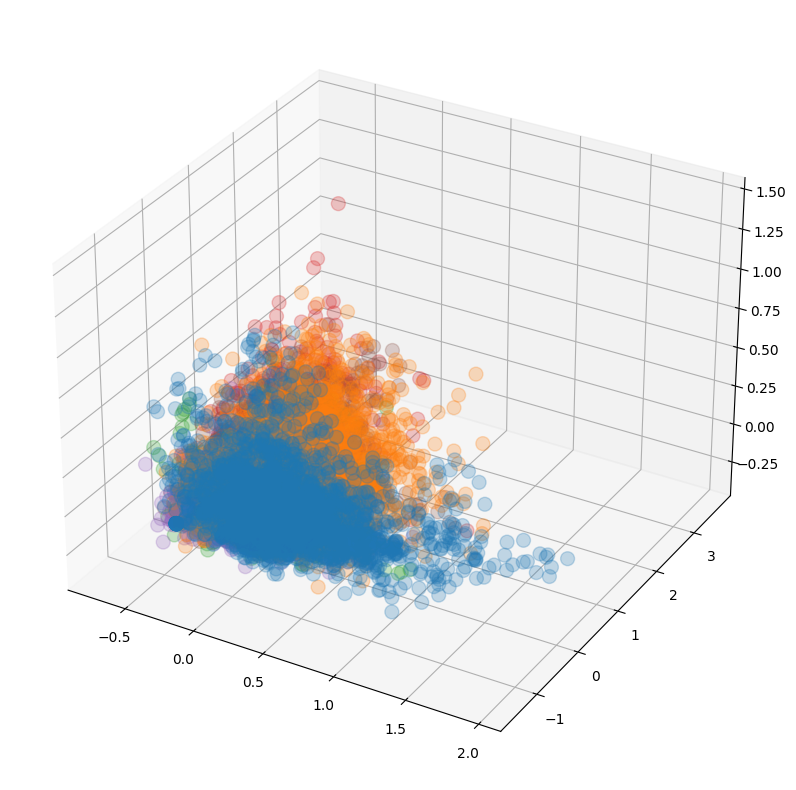


Skelly EDA
                  f            x1            x2            x3            x4   
count  20792.000000  20792.000000  20792.000000  20792.000000  20792.000000  \
mean    5431.924105      0.504564      0.401233      0.387701      0.513251   
std     3190.755855      0.235440      0.144886      0.298025      0.236656   
min        0.000000     -0.001065      0.015167      0.000000      0.013889   
25%     2395.000000      0.342593      0.309783      0.000000      0.348380   
50%     5808.000000      0.506200      0.385870      0.395189      0.513889   
75%     8239.000000      0.675926      0.472826      0.663697      0.685185   
max    10480.000000      0.983223      0.951087      0.996066      0.986111   

                 x5            x6            x7            x8            x9   
count  20792.000000  20792.000000  20792.000000  20792.000000  20792.000000  \
mean       0.426756      0.517425      0.500958      0.426983      0.453498   
std        0.144956      0.214885      

/tmp/ipykernel_406/2796088225.py:118: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(df[km.labels_ == i][0], df[km.labels_ == i][1], df[km.labels_ == i][2], alpha=0.25, s=100, cmap='rainbow')


The centroid of the cluster number 0 is 0.16848331506221553 0.11020306969434307
The frame with the minimum distance to the centroid is 1953 so the frame is in the minute 33 and second 33 of the video
The centroid of the cluster number 1 is 0.166261084400704 0.11386550080629185
The frame with the minimum distance to the centroid is 476 so the frame is in the minute 8 and second 56 of the video
The centroid of the cluster number 2 is 0.14139318976868537 0.12290038169502869
The frame with the minimum distance to the centroid is 306 so the frame is in the minute 5 and second 6 of the video
The centroid of the cluster number 3 is -0.38329011338791674 -0.27423046144345004
The frame with the minimum distance to the centroid is 0 so the frame is in the minute 0 and second 0 of the video
The centroid of the cluster number 4 is 0.1664899350953937 0.1049095629042443
The frame with the minimum distance to the centroid is 1254 so the frame is in the minute 21 and second 54 of the video
The centroid

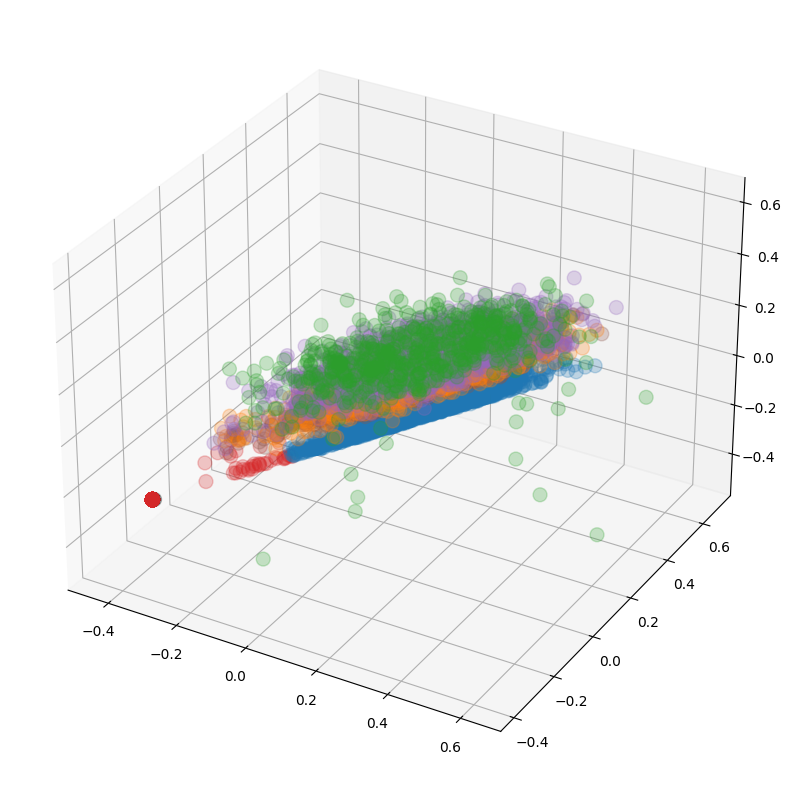


t-SNE
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 10482 samples in 0.003s...
[t-SNE] Computed neighbors for 10482 samples in 1.107s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10482
[t-SNE] Computed conditional probabilities for sample 2000 / 10482
[t-SNE] Computed conditional probabilities for sample 3000 / 10482
[t-SNE] Computed conditional probabilities for sample 4000 / 10482
[t-SNE] Computed conditional probabilities for sample 5000 / 10482
[t-SNE] Computed conditional probabilities for sample 6000 / 10482
[t-SNE] Computed conditional probabilities for sample 7000 / 10482
[t-SNE] Computed conditional probabilities for sample 8000 / 10482
[t-SNE] Computed conditional probabilities for sample 9000 / 10482
[t-SNE] Computed conditional probabilities for sample 10000 / 10482
[t-SNE] Computed conditional probabilities for sample 10482 / 10482
[t-SNE] Mean sigma: 2.446875
[t-SNE] Computed conditional probabilities in 0.497s
[t-SNE] Iteration 50: error 

/tmp/ipykernel_406/2796088225.py:143: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(tsne[:, 0], tsne[:, 1], alpha=0.25, s=100, cmap='rainbow')


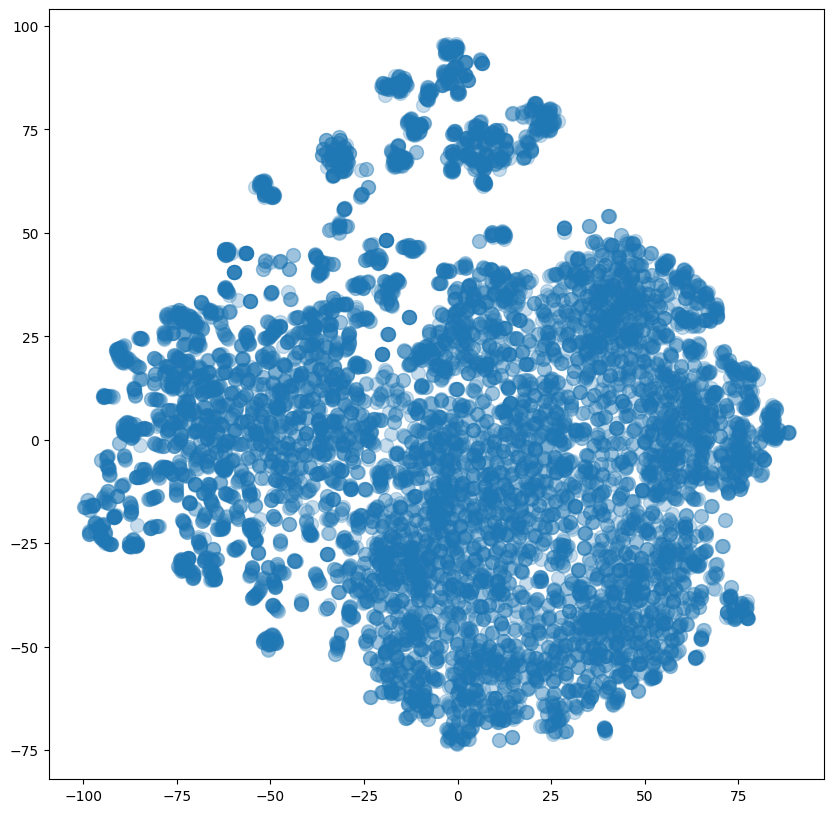


t-SNE
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 10480 samples in 0.010s...
[t-SNE] Computed neighbors for 10480 samples in 2.288s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10480
[t-SNE] Computed conditional probabilities for sample 2000 / 10480
[t-SNE] Computed conditional probabilities for sample 3000 / 10480
[t-SNE] Computed conditional probabilities for sample 4000 / 10480
[t-SNE] Computed conditional probabilities for sample 5000 / 10480
[t-SNE] Computed conditional probabilities for sample 6000 / 10480
[t-SNE] Computed conditional probabilities for sample 7000 / 10480
[t-SNE] Computed conditional probabilities for sample 8000 / 10480
[t-SNE] Computed conditional probabilities for sample 9000 / 10480
[t-SNE] Computed conditional probabilities for sample 10000 / 10480
[t-SNE] Computed conditional probabilities for sample 10480 / 10480
[t-SNE] Mean sigma: 0.000000
[t-SNE] Computed conditional probabilities in 1.684s
[t-SNE] Iteration 50: error 

/tmp/ipykernel_406/2796088225.py:143: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(tsne[:, 0], tsne[:, 1], alpha=0.25, s=100, cmap='rainbow')


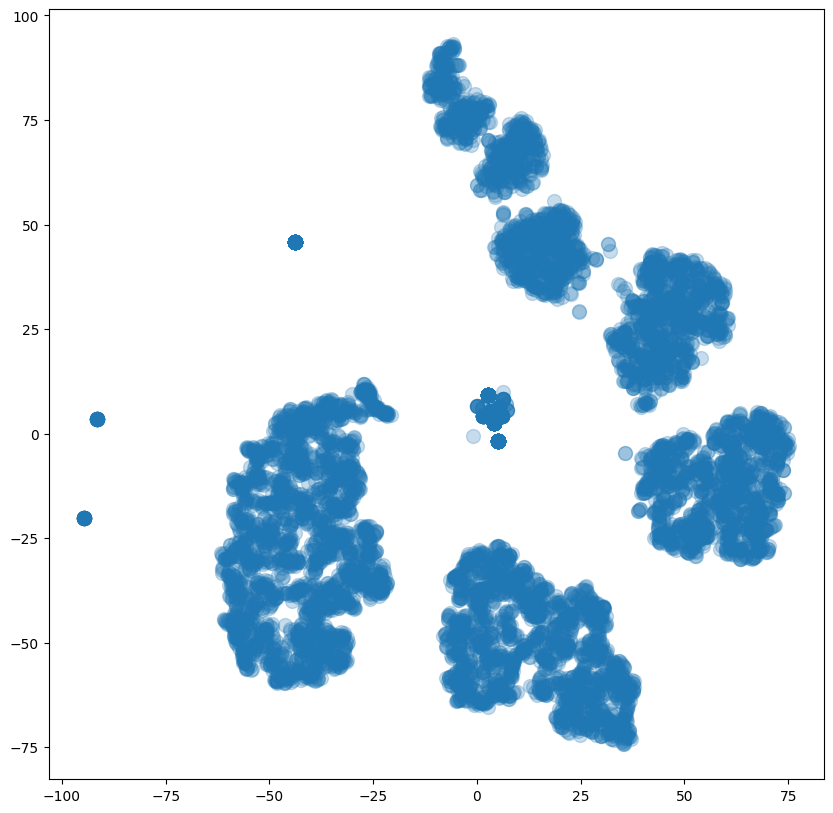

In [11]:
def main():
    data = BData("Data/girosmallveryslow2_openpose_complete.mat",
                 "Data/girosmallveryslow2_vggfeatures.mat")
    data.EDA_VGG()
    data.PCA_VGG()
    data.VGG_df=data.center_data(data.VGG_df)
    data.kmeans(data.VGG_df)
    data.EDA_skelly()
    data.PCA_skelly()
    data.skeleton_df=data.center_data(data.skeleton_df)
    data.kmeans(data.skeleton_df)
    data.t_SNE(data.VGG_df)
    data.t_SNE(data.skeleton_df)

if __name__ == '__main__':
    main()